In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from GraphLaplacian.binary import GraphLaplacian, MBOBinary
from GraphLaplacian.multilabel import GLMultiClass, MBOMultiClass
from GraphLaplacian.helper import plot, plot2d
import pdb
from IPython.display import clear_output
from sklearn.datasets import make_moons, make_circles, make_classification
import scipy
import pdb
from datetime import datetime
import itertools

matplotlib.rcParams['figure.figsize'] = [5, 5]
sns.set()
sns.set_style("ticks")

In [4]:
import random
import math

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def create_score_sheet(method, y_true, y_pred):
    return {"Method":method, 
            "accuracy":accuracy_score(y_true, y_pred), 
            "f1_score": f1_score(y_true, y_pred), 
            "presicion": precision_score(y_true, y_pred), 
            "recall": recall_score(y_true, y_pred)}

def find_h(X, n_sample=5, n_neigh=5, use_mean=False):
    np.random.seed(1000)
    tree = scipy.spatial.cKDTree(X)
    sample = random.sample(X, k=n_sample)
    _func = lambda point: np.mean([x for x in tree.query(point, k = n_neigh+1)[0] if x > 0])
    if use_mean:
        h = np.mean([_func(x) for x in sample])
    else:
        h = np.max([_func(x) for x in sample])
    return h

# Xr = random.choices(X, k=10)

In [5]:
colors = ["#ffffff", "#ff6361", "#003f5c", "#63005c", "#006355", "#5c3f00"]
sns.set_palette(sns.color_palette(colors))

In [6]:
wcut_to_denum = lambda x: np.sqrt(-2*np.log(x))
denum_to_wcut = lambda x: np.exp(-(x**2)/2)

In [7]:
denum_to_wcut(6)

1.522997974471263e-08

In [8]:
def plot_case(X0, Y0, X1, return_ax=False, title=""):
    colors = ["#ed705c", "#79b1ed", "#ffb3ff", "#82d4d1", "#f5dd9f"]
    sns.set_palette(sns.color_palette(colors))

    xx = [x[0] for x in X1]
    xy = [x[1] for x in X1]
    max_lim = max(max(xx), max(xy)) + 0.1
    min_lim = min(min(xx), min(xy)) + 0.1

    fig, ax = plt.subplots()
    ax.scatter(xx, xy, label="unknown", s=7, color="#cccccc")

    df = pd.DataFrame(X0, columns=["x1", "x2"])
    df.loc[:, "label"] = ["Initial_" + str(Y0[i]) if i < len(Y0) else "unknown" for i, y in enumerate(X0)]
    df = df.sort_values(by=["label"], ascending=True)
    colors = ["#691b05", "#071e7a", "#690664", "#006355", "#5c3f00"]
    for i, label in enumerate(df[df["label"] != "unknown"].label.unique()):
        dplot = df[df["label"] == label]
        ax.scatter(dplot["x1"], dplot["x2"], label=label, s=20, marker="x", color=colors[i])
    # ax.scatter(np.array(X0).T[0], np.array(X0).T[1], label="Initial Data", s=15, marker="x", color="red")

    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    ax.set_title(title)

    ax.legend()
    if return_ax:
        return ax
    plt.show()

In [24]:
from multiprocessing import Process, Manager

manager = Manager()

# a

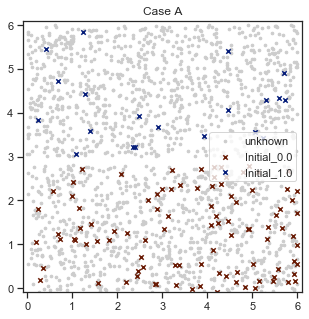

In [22]:
np.random.seed(1000)
blue = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 + 3))
red = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 - 0.2))
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)

N = 20
gamma = 5
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]
plot_case(X0, Y0, X1, title="Case A")

In [25]:
denums = [1, 2, 3, 3.6, 4, 5]
dataa = manager.list()

def run_single(d, dataa):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    # w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    w_cut = denum_to_wcut(d)*0.99
    GL = GraphLaplacian(list(X0), list(Y0), list(X1), sigma=h, w_cut=w_cut)
    GL.solve()
    score = f1_score(Y, GL.Y)
    dataa.append({"Alg":"GL", "denum":d, "wcut":w_cut, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})
    
procs = list()
for d in denums:
    p = Process(target=run_single, args=(d,dataa))
    p.start()
    procs.append(p)

for p in procs:
    p.join()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    
pd.DataFrame(list(dataa)).sort_values("denum")

Graph Laplacian, denum=1
Graph Laplacian, denum=2
Graph Laplacian, denum=3
Graph Laplacian, denum=5
Graph Laplacian, denum=4
Graph Laplacian, denum=3.6
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.9}
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.9}
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.9}
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.9}
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.9}
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.8938097634625063}


,Alg,denum,wcut,f1-score
0,GL,1.0,0.600465,0.90000
1,GL,2.0,0.133982,0.90000
2,GL,3.0,0.010998,0.90000
3,GL,3.6,0.001518,0.90000
4,GL,4.0,0.000332,0.90000
5,GL,5.0,0.000004,0.89381


In [26]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))
dataa_mbo = manager.list()

# for d, t in pairs:
#     h = find_h(list(X), len(X), 1, use_mean=False)/d
#     print("MBO, (denum, dT) : ({}, {})".format(d, t))
#     mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
#     mbo.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, mbo.Y)
#     dataa_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
#     print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})dataa_mbo = manager.list()

def run_single(d, t, dataa_mbo):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    w_cut = denum_to_wcut(d)*0.99
    mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
    mbo.solve()
    score = f1_score(Y, mbo.Y)
    dataa_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "w_cut":w_cut, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    
procs = list()
for d, t in pairs:
    p = Process(target=run_single, args=(d,t,dataa_mbo))
    p.start()
    procs.append(p)

for p in procs:
    p.join()

MBO, (denum, dT) : (1, 0.1)
MBO, (denum, dT) : (1, 0.01)
MBO, (denum, dT) : (1, 0.005)
MBO, (denum, dT) : (1, 0.001)
MBO, (denum, dT) : (2, 0.1)
MBO, (denum, dT) : (2, 0.005)
MBO, (denum, dT) : (3.6, 0.01)
MBO, (denum, dT) : (3, 0.1)
MBO, (denum, dT) : (3.6, 0.1)
MBO, (denum, dT) : (3, 0.001)
MBO, (denum, dT) : (3, 0.01)
MBO, (denum, dT) : (2, 0.001)
MBO, (denum, dT) : (3.6, 0.005)
MBO, (denum, dT) : (2, 0.01)
MBO, (denum, dT) : (5, 0.01)
MBO, (denum, dT) : (3, 0.005)
MBO, (denum, dT) : (4, 0.01)
MBO, (denum, dT) : (5, 0.001)
MBO, (denum, dT) : (4, 0.001)
MBO, (denum, dT) : (3.6, 0.001)
MBO, (denum, dT) : (5, 0.1)
MBO, (denum, dT) : (4, 0.005)
MBO, (denum, dT) : (5, 0.005)
MBO, (denum, dT) : (4, 0.1)
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Ca

In [27]:
pd.DataFrame(list(dataa_mbo))\
    .pivot_table("f1-score",["Alg", "dT"],["denum","w_cut"])\
    .reset_index().sort_values("dT", ascending=False)

denum,Alg,dT,1.0,2.0,3.0,3.6,4.0,5.0
w_cut,,,0.6004653531155071,0.13398193040424658,0.010997906572859883,0.0015184725725312185,0.00033210800162348673,3.689386640357884e-06
3,MBO,0.100,0.756507,0.681537,0.538462,0.483113,0.436502,0.338487
2,MBO,0.010,0.547222,0.501086,0.390282,0.337408,0.313433,0.269165
1,MBO,0.005,0.547222,0.501086,0.390282,0.337408,0.313433,0.279424
0,MBO,0.001,0.547222,0.501086,0.390282,0.337408,0.313433,0.303586


# b

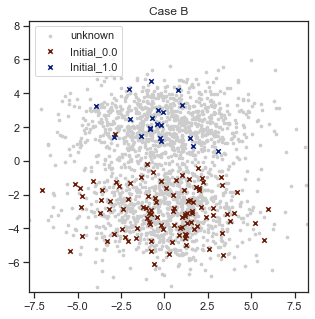

In [35]:
np.random.seed(1000)
cov1 = np.array([[6,0],[0,2]])
blue = np.random.multivariate_normal(mean=[0,2], cov=cov1, size=1000)
cov2 = np.array([[6,0],[0,2]])
red = np.random.multivariate_normal(mean=[0,-3], cov=cov2, size=1000)
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)
h = find_h(X, len(X), 1, use_mean=False)/3.6

N = 20
gamma = 5
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]

plot_case(X0, Y0, X1, title="Case B")

In [36]:
# for d in denums:
#     h = find_h(X, len(X), 1, use_mean=False)/d
#     print("Graph Laplacian, denum={}".format(d))
#     w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
#     GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=w_cut)
#     GL.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, GL.Y)
#     datab.append({"Alg":"GL", "denum":d, "f1-score":score})
#     print({"Alg":"GL", "denum":d, "f1-score":score})

denums = [1, 2, 3, 3.6, 4, 5]
datab = manager.list()

def run_single(d, datab):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    # w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    w_cut = denum_to_wcut(d)*0.99
    GL = GraphLaplacian(list(X0), list(Y0), list(X1), sigma=h, w_cut=w_cut)
    GL.solve()
    score = f1_score(Y, GL.Y)
    datab.append({"Alg":"GL", "denum":d, "wcut":w_cut, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})
    
procs = list()
for d in denums:
    p = Process(target=run_single, args=(d,datab))
    p.start()
    procs.append(p)

for p in procs:
    p.join()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    
pd.DataFrame(list(datab)).sort_values("denum")

Graph Laplacian, denum=2
Graph Laplacian, denum=5
Graph Laplacian, denum=3
Graph Laplacian, denum=4
Graph Laplacian, denum=3.6
Graph Laplacian, denum=1
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.8448637316561846}
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.8479166666666667}
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.8503118503118503}
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.850909090909091}
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.850909090909091}
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.8495575221238938}


,Alg,denum,wcut,f1-score
0,GL,1.0,0.600465,0.844864
1,GL,2.0,0.133982,0.847917
2,GL,3.0,0.010998,0.850312
3,GL,3.6,0.001518,0.850909
4,GL,4.0,0.000332,0.850909
5,GL,5.0,0.000004,0.849558


In [37]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))
datab_mbo = manager.list()

def run_single(d, t, datab_mbo):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    w_cut = denum_to_wcut(d)*0.99
    mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
    mbo.solve()
    score = f1_score(Y, mbo.Y)
    datab_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "w_cut":w_cut, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    
procs = list()
for d, t in pairs:
    p = Process(target=run_single, args=(d,t,datab_mbo))
    p.start()
    procs.append(p)

for p in procs:
    p.join()

# for d, t in pairs:
#     h = find_h(list(X), len(X), 1, use_mean=False)/d
#     print("MBO, (denum, dT) : ({}, {})".format(d, t))
#     mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
#     mbo.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, mbo.Y)
#     datab_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
#     print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})

MBO, (denum, dT) : (1, 0.01)
MBO, (denum, dT) : (1, 0.1)
MBO, (denum, dT) : (4, 0.001)
MBO, (denum, dT) : (1, 0.005)
MBO, (denum, dT) : (3.6, 0.1)
MBO, (denum, dT) : (3.6, 0.01)
MBO, (denum, dT) : (4, 0.1)
MBO, (denum, dT) : (2, 0.1)
MBO, (denum, dT) : (2, 0.01)
MBO, (denum, dT) : (3, 0.005)
MBO, (denum, dT) : (3.6, 0.005)
MBO, (denum, dT) : (1, 0.001)
MBO, (denum, dT) : (3.6, 0.001)
MBO, (denum, dT) : (2, 0.005)
MBO, (denum, dT) : (3, 0.01)
MBO, (denum, dT) : (3, 0.1)
MBO, (denum, dT) : (2, 0.001)
MBO, (denum, dT) : (4, 0.005)
MBO, (denum, dT) : (4, 0.01)
MBO, (denum, dT) : (3, 0.001)
MBO, (denum, dT) : (5, 0.1)
MBO, (denum, dT) : (5, 0.001)
MBO, (denum, dT) : (5, 0.005)
MBO, (denum, dT) : (5, 0.01)
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Calculate weight matrix... DONE
Ca

In [38]:
pd.DataFrame(list(datab_mbo))\
    .pivot_table("f1-score",["Alg", "dT"],["denum","w_cut"])\
    .reset_index().sort_values("dT", ascending=False)

denum,Alg,dT,1.0,2.0,3.0,3.6,4.0,5.0
w_cut,,,0.6004653531155071,0.13398193040424658,0.010997906572859883,0.0015184725725312185,0.00033210800162348673,3.689386640357884e-06
3,MBO,0.100,0.857438,0.850000,0.831293,0.821888,0.805464,0.787507
2,MBO,0.010,0.824919,0.822581,0.796901,0.781390,0.771234,0.754913
1,MBO,0.005,0.813890,0.808928,0.800000,0.786392,0.730701,0.696180
0,MBO,0.001,0.783632,0.779470,0.761905,0.756477,0.746512,0.714115


# c

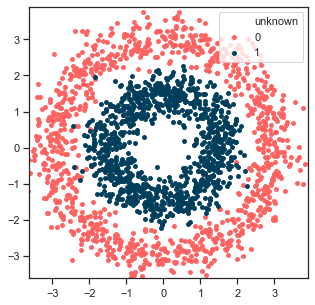

In [47]:
X, Y = make_circles(noise=0.11, factor=0.5, random_state=1, n_samples=2000)
X = X * 3

plot(X,Y,[])

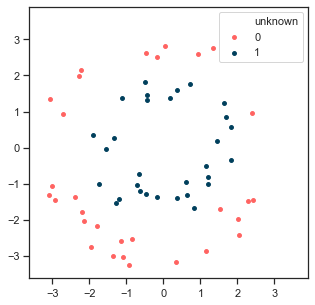

In [48]:
N = 30
gamma = 1
X0 = list([X[i] for i,y in enumerate(Y) if y==0][:N] + [X[i] for i,y in enumerate(Y) if y==1][:gamma*N])
Y0 = list([y for y in Y if y==0][:N] + [y for y in Y if y==1][:gamma*N])
X1 = list(X[(1+gamma)*N:])
# X = X0 + X1
plot(X0, Y0, X1)

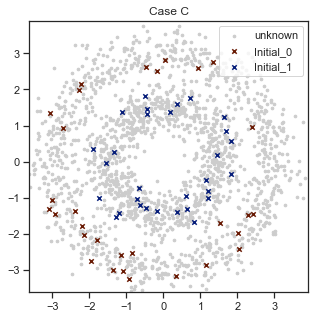

In [49]:
plot_case(X0, Y0, X1, title="Case C")

In [41]:
denums = [1, 2, 3, 3.6, 4, 5]
datac = manager.list()

def run_single(d, datac):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    # w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    w_cut = denum_to_wcut(d)*0.99
    GL = GraphLaplacian(list(X0), list(Y0), list(X1), sigma=h, w_cut=w_cut)
    GL.solve()
    score = f1_score(Y, GL.Y)
    datac.append({"Alg":"GL", "denum":d, "wcut":w_cut, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})
    
procs = list()
for d in denums:
    p = Process(target=run_single, args=(d,datac))
    p.start()
    procs.append(p)

for p in procs:
    p.join()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    
pd.DataFrame(list(datac)).sort_values("denum")
# for d in denums:
#     h = find_h(list(X), len(X), 1, use_mean=False)/d
#     print("Graph Laplacian, denum={}".format(d))
#     GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=denum_to_wcut(d)*0.99)
#     GL.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, GL.Y)
#     datac.append({"Alg":"GL", "denum":d, "f1-score":score})
#     print({"Alg":"GL", "denum":d, "f1-score":score})

Graph Laplacian, denum=1
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.9688273132112815}
Graph Laplacian, denum=2
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.9712301587301587}
Graph Laplacian, denum=3
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.9721393034825871}
Graph Laplacian, denum=3.6
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.9716276754604282}
Graph Laplacian, denum=4
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.9706028898854012}
Graph Laplacian, denum=5
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.9705441837244133}


In [54]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))



# datac_mbo = list()
# for d, t in pairs:
#     h = find_h(list(X), len(X), 1, use_mean=False)/d
#     print("MBO, (denum, dT) : ({}, {})".format(d, t))
#     mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
#     mbo.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, mbo.Y)
#     datac_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
#     print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})

MBO, (denum, dT) : (1, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.4727095516569201
Interation 1 error 0.0058823529411764705
Interation 2 error 0.0019646365422396855
Interation 3 error 0.001968503937007874
Interation 4 error 0.0
{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.9702380952380953}
MBO, (denum, dT) : (1, 0.01)
Calculate weight matrix... DONE
Interation 0 error 0.47317073170731705
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.9639506172839506}
MBO, (denum, dT) : (1, 0.005)
Calculate weight matrix... DONE
Interation 0 error 0.474559686888454
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.9624134520276955}
MBO, (denum, dT) : (1, 0.001)
Calculate weight matrix... DONE
Interation 0 error 0.48597194388777554
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.9669669669669669}
MBO, (denum, dT) : (2, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.4717898832684825
Inter

In [71]:
df = pd.DataFrame(datac_mbo)
#df.loc[:, "f1-score"] = df["f1-score"]*100
df = df.pivot("dT", "denum", "f1-score").reset_index()
df.sort_values(["dT"], ascending=False)

denum,dT,1.0,2.0,3.0,3.6,4.0,5.0
3,0.100,0.970238,0.963475,0.963366,0.961787,0.962189,0.960725
2,0.010,0.963951,0.960474,0.941783,0.907930,0.894283,0.842105
1,0.005,0.962413,0.964304,0.941783,0.907930,0.897959,0.853303
0,0.001,0.966967,0.964304,0.941783,0.908511,0.897959,0.871145


# multi

In [62]:
manager = Manager()

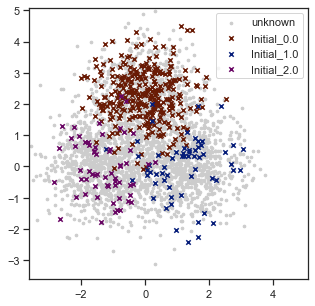

In [60]:
np.random.seed(500)
cov = np.array([[0.7,0],[0,0.7]])
one = np.random.multivariate_normal(mean=[0,1.73*1.3], cov=cov, size=1000)
two = np.random.multivariate_normal(mean=[1.3,0], cov=cov, size=1000)
tree = np.random.multivariate_normal(mean=[-1.3,0], cov=cov, size=1000)

N0 = 60
N01 = 5*N0
N02 = N0
N03 = N0
X0 = list(one[:N01]) + list(two[:N02]) + list(tree[:N03])
Y0 = list(np.ones(N01)*0) + list(np.ones(N02)*1) + list(np.ones(N03)*2)
X1 = list(one[N01:]) + list(two[N02:]) + list(tree[N03:])
Y1 = list(np.ones(len(one) - N01)*0) + list(np.ones(len(two) - N02)*1) + list(np.ones(len(tree) - N03)*2)
X = list(X0) + list(X1)
Y = list(Y0) + list(Y1)

#Xr = random.choices(X, k=100)
h = find_h(X, len(X), 1, use_mean=False)/3.6
plot_case(X0, Y0, X1)

In [58]:
denums = [1, 2, 3, 3.6, 4, 5]
datam = manager.list()

def run_single(d, datam):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    # w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    w_cut = denum_to_wcut(d)*0.99
    GL = GLMultiClass(list(X0), list(Y0), list(X1), sigma=h, w_cut=w_cut)
    GL.solve()
    score = f1_score(Y, GL.Y, average="weighted")
    datam.append({"Alg":"GL", "denum":d, "wcut":w_cut, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})
    
procs = list()
for d in denums:
    p = Process(target=run_single, args=(d,datam))
    p.start()
    procs.append(p)

for p in procs:
    p.join()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    
pd.DataFrame(list(datam)).sort_values("denum")
# for d in denums:
#     h = find_h(list(X), len(X), 1, use_mean=False)/d
#     print("Graph Laplacian, denum={}".format(d))
#     GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=denum_to_wcut(d)*0.99)
#     GL.solve()
#     #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
#     score = f1_score(Y, GL.Y)
#     datac.append({"Alg":"GL", "denum":d, "f1-score":score})
#     print({"Alg":"GL", "denum":d, "f1-score":score})

Graph Laplacian, denum=1
Graph Laplacian, denum=2
Graph Laplacian, denum=3
Graph Laplacian, denum=3.6
Graph Laplacian, denum=4
Graph Laplacian, denum=5
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.8841647110491783}
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.8790267958710934}
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.8851980336324509}
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.8823352497955869}
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.8774736253483173}
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.8839066495052521}


,Alg,denum,wcut,f1-score
4,GL,1.0,0.600465,0.877474
3,GL,2.0,0.133982,0.882335
2,GL,3.0,0.010998,0.885198
0,GL,3.6,0.001518,0.884165
5,GL,4.0,0.000332,0.883907
1,GL,5.0,0.000004,0.879027


In [66]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
datam_mbo = manager.list()

def run_single(d, t, datam_mbo):
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    w_cut = denum_to_wcut(d)*0.99
    mbo = MBOMultiClass(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99)
    mbo.solve()
    score = f1_score(Y, mbo.Y, average="weighted")
    datam_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "w_cut":w_cut, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    
procs = list()
for d, t in pairs:
    p = Process(target=run_single, args=(d,t,datam_mbo))
    p.start()
    procs.append(p)

for p in procs:
    p.join()

MBO, (denum, dT) : (1, 0.1)
MBO, (denum, dT) : (1, 0.01)
MBO, (denum, dT) : (1, 0.001)
MBO, (denum, dT) : (1, 0.005)
MBO, (denum, dT) : (3, 0.1)
MBO, (denum, dT) : (2, 0.01)
MBO, (denum, dT) : (3, 0.01)
MBO, (denum, dT) : (2, 0.001)
MBO, (denum, dT) : (3, 0.005)
MBO, (denum, dT) : (3, 0.001)
MBO, (denum, dT) : (2, 0.1)
MBO, (denum, dT) : (3.6, 0.1)
MBO, (denum, dT) : (2, 0.005)
MBO, (denum, dT) : (3.6, 0.005)
MBO, (denum, dT) : (4, 0.005)
MBO, (denum, dT) : (4, 0.1)
MBO, (denum, dT) : (3.6, 0.01)
MBO, (denum, dT) : (4, 0.001)
MBO, (denum, dT) : (4, 0.01)
MBO, (denum, dT) : (3.6, 0.001)
MBO, (denum, dT) : (5, 0.1)
MBO, (denum, dT) : (5, 0.01)
MBO, (denum, dT) : (5, 0.005)
MBO, (denum, dT) : (5, 0.001)
Creating weight matrix cost 0:08:53.177198
Creating weight matrix cost 0:08:53.550692
Creating weight matrix cost 0:08:53.901173
Creating weight matrix cost 0:08:54.656324
Creating weight matrix cost 0:08:55.052413
Creating weight matrix cost 0:08:54.489391
Creating weight matrix cost 0:08

In [73]:
datab_mbo = [
    {'Alg': 'MBO', 'dT': 0.01, 'denum': 3, 'f1-score': 0.8680756699632517},
    {'Alg': 'MBO', 'dT': 0.001, 'denum': 3, 'f1-score': 0.8651318975957498},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 3.6, 'f1-score': 0.8628700186418744},
{'Alg': 'MBO', 'dT': 0.001, 'denum': 5, 'f1-score': 0.8566619026171715},
{'Alg': 'MBO', 'dT': 0.01, 'denum': 5, 'f1-score': 0.859812080848615},
{'Alg': 'MBO', 'dT': 0.001, 'denum': 2, 'f1-score': 0.8689440972537424},
{'Alg': 'MBO', 'dT': 0.001, 'denum': 3.6, 'f1-score': 0.8612419789553201},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 3.6, 'f1-score': 0.8737053006413968},
{'Alg': 'MBO', 'dT': 0.01, 'denum': 4, 'f1-score': 0.86222894942639},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 3, 'f1-score': 0.8670973201148418},
{'Alg': 'MBO', 'dT': 0.01, 'denum': 3.6, 'f1-score': 0.8645699851047168},
{'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.8662542228645298},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 5, 'f1-score': 0.8583708127020809},
{'Alg': 'MBO', 'dT': 0.01, 'denum': 2, 'f1-score': 0.87031227789209},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 2, 'f1-score': 0.8705888872014149},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 4, 'f1-score': 0.860859229266029},
{'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.8671759870181358},
{'Alg': 'MBO', 'dT': 0.001, 'denum': 4, 'f1-score': 0.860887369026242},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 2, 'f1-score': 0.8786836482929061},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 4, 'f1-score': 0.8737562128910755},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.8755057913731885},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 3, 'f1-score': 0.8746460680795866},
{'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.8675036013134304},
{'Alg': 'MBO', 'dT': 0.1, 'denum': 5, 'f1-score': 0.8714376512675168}
]

In [78]:
df = pd.DataFrame(list(datab_mbo))\
    .pivot_table("f1-score",["Alg", "dT"],["denum"])\
    .reset_index().sort_values("dT", ascending=False)
df

denum,Alg,dT,1.0,2.0,3.0,3.6,4.0,5.0
3,MBO,0.100,0.875506,0.878684,0.874646,0.873705,0.873756,0.871438
2,MBO,0.010,0.867176,0.870312,0.868076,0.864570,0.862229,0.859812
1,MBO,0.005,0.867504,0.870589,0.867097,0.862870,0.860859,0.858371
0,MBO,0.001,0.866254,0.868944,0.865132,0.861242,0.860887,0.856662


In [89]:
for data in df.iterrows():
    print(" & ".join([str(round(x*100,2)) + "\\%" for x in list(data[1])[2:]]))

87.55\% & 87.87\% & 87.46\% & 87.37\% & 87.38\% & 87.14\%
86.72\% & 87.03\% & 86.81\% & 86.46\% & 86.22\% & 85.98\%
86.75\% & 87.06\% & 86.71\% & 86.29\% & 86.09\% & 85.84\%
86.63\% & 86.89\% & 86.51\% & 86.12\% & 86.09\% & 85.67\%


In [ ]:
print(" & ".join([str(round(x*100,2)) + "\\%" for x in list(data[1])[2:]]))